In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import pandas as pd
#df = pd.read_csv("/content/drive/MyDrive/Review/all-data.csv",encoding= 'latin-1', names=["sentiment", "text"] )

In [5]:
#print(df.info())

In [6]:
#print(df.head(15))


In [7]:
#print(df['text'].nunique())

In [8]:
#df.describe()

#Step 1: Import libraries & load dataset

In [9]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [10]:
# Load your dataset
#df = pd.read_csv("/content/drive/MyDrive/Review/all-data.csv",encoding= 'latin-1', names=["sentiment", "text"] )
df = pd.read_csv("/content/drive/MyDrive/Review/all-data.csv" ,encoding= 'latin-1', header=None, names=["label", "text"])

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])  # positive=2, neutral=1, negative=0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label_encoded'], test_size=0.2, random_state=42, stratify=df['label_encoded']
)


In [11]:
df.head()

,label,text,label_encoded
0,neutral,"According to Gran , the company has no plans t...",1
1,neutral,Technopolis plans to develop in stages an area...,1
2,negative,The international electronic industry company ...,0
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2


# 🔹 Step 2: Text Preprocessing

In [12]:
# Clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = text.lower()
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)


# 🔹 Step 3: Tokenization & Padding

In [13]:
MAX_NUM_WORDS = 20000
MAX_SEQ_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding="post")

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


# 🔹 Step 4: Load Word2Vec / GloVe Embeddings

👉 You need a pretrained embedding file like:

GoogleNews-vectors-negative300.bin (Word2Vec)

glove.6B.100d.txt (GloVe)

In [18]:
# Example with GloVe (100d)
embedding_index = {}
# Update the path to your GloVe file in Google Drive by copying it from the Colab file browser
glove_file_path = "/content/drive/MyDrive/Review/glove.6B.100d.txt" # <--- PASTE THE CORRECT PATH HERE

with open(glove_file_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

EMBEDDING_DIM = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Step 5: Build LSTM Model

In [19]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1,
                    output_dim=EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQ_LENGTH,
                    trainable=False))   # keep pretrained embeddings frozen

model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 sentiment classes

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       993,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993,000 (3.79 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 993,000 (3.79 MB)

# Step 6: Train Model

In [20]:
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 383ms/step - accuracy: 0.5704 - loss: 1.0024 - val_accuracy: 0.5619 - val_loss: 0.9107
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 317ms/step - accuracy: 0.6062 - loss: 0.8851 - val_accuracy: 0.5954 - val_loss: 0.9449
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.5752 - loss: 0.9740 - val_accuracy: 0.5954 - val_loss: 0.9343
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - accuracy: 0.5817 - loss: 0.9658 - val_accuracy: 0.5954 - val_loss: 0.9283
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 325ms/step - accuracy: 0.5984 - loss: 0.9507 - val_accuracy: 0.5954 - val_loss: 0.9299
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 352ms/step - accuracy: 0.5970 - loss: 0.9426 - val_accuracy: 0.5954 - val_loss: 0.9294
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 329ms/step - accuracy: 0.5976 - loss: 0.9344 - val_accuracy: 0.5954 - val_loss: 0.9289
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 308ms/step - accuracy: 0.5940 - loss: 0.9435 - val_accu

# Step 7: Evaluate Model

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5987 - loss: 0.9202
Test Accuracy: 0.59
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


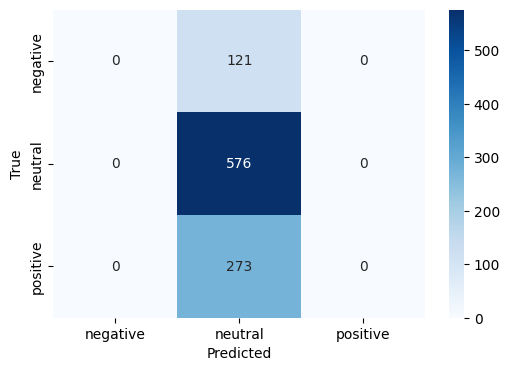

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       121
     neutral       0.59      1.00      0.75       576
    positive       0.00      0.00      0.00       273

    accuracy                           0.59       970
   macro avg       0.20      0.33      0.25       970
weighted avg       0.35      0.59      0.44       970



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
loss, acc = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Accuracy: {acc:.2f}")

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_pad).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_test, y_pred, target_names=le.classes_))


# Step 8: Visualize Training

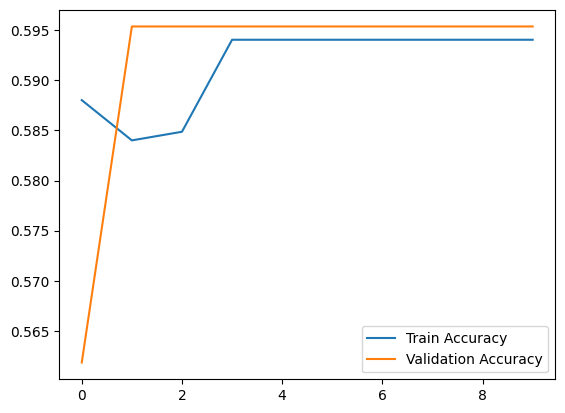

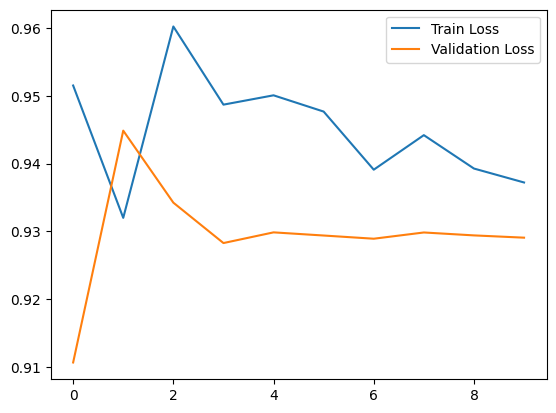

In [22]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
